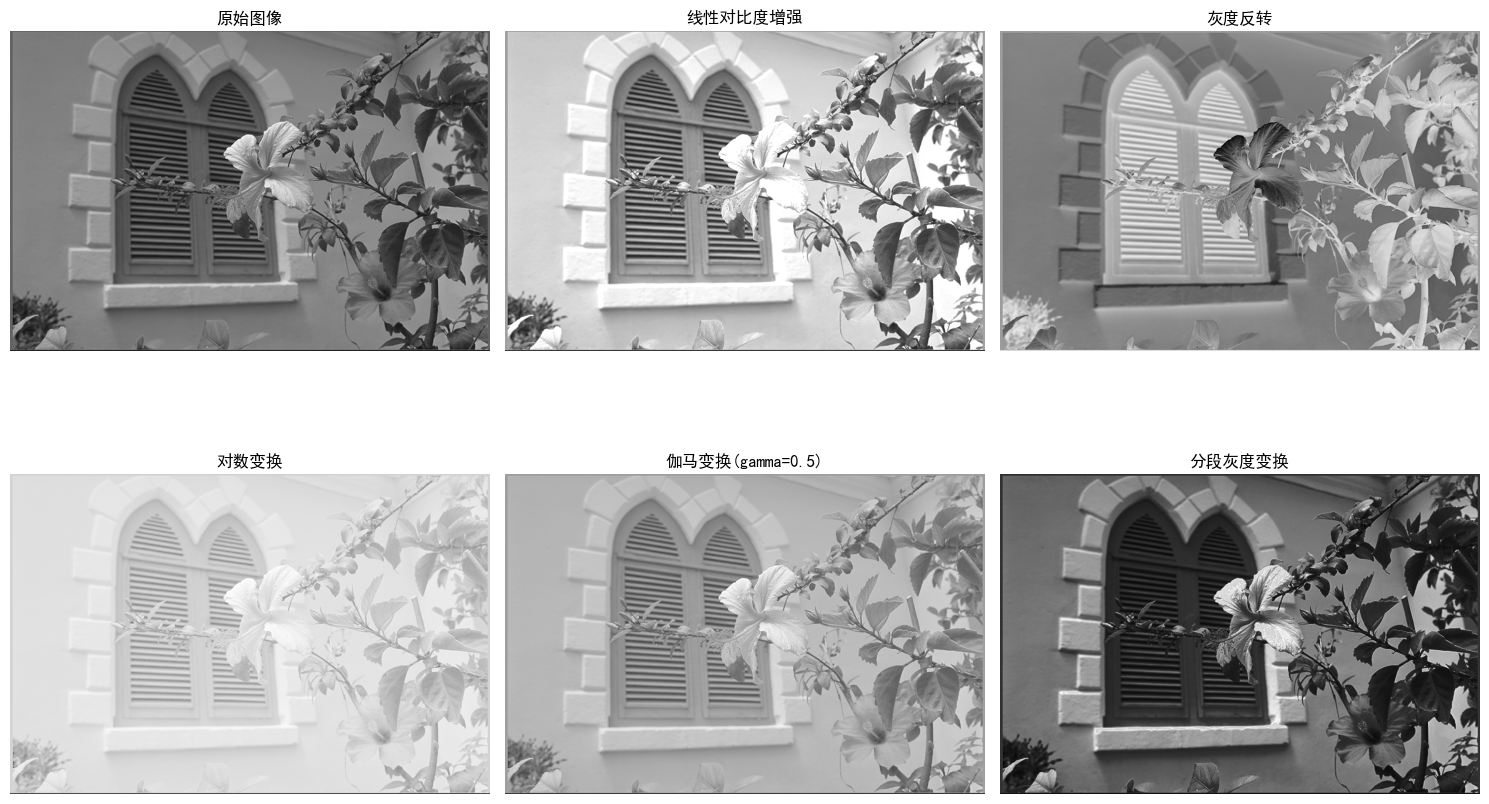

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_path = "test.jpg"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

if img is None:
    print(f"警告：无法读取图片 {img_path}，自动生成模拟灰度图")
    img = np.uint8(np.random.normal(100, 30, (400, 400)))
    img = np.clip(img, 0, 255)

if np.max(img) == 0:
    print("警告：图像全黑，自动添加微小亮度值避免计算错误")
    img = np.clip(img + 1, 0, 255)

# 2. 线性灰度变换
# 对比度增强
k = 1.5
b = 20
linear_enhance = np.clip(k * img + b, 0, 255).astype(np.uint8)
# 灰度反转
linear_invert = 255 - img

# 3. 非线性灰度变换
# 先将图像转换为float64，提升运算精度，避免uint8溢出
img_float = img.astype(np.float64)
img_max = np.max(img_float)

# 对数变换
c_log = 255 / np.log(1 + img_max + 1e-8)
log_transform = c_log * np.log(1 + img_float)
log_transform = np.uint8(np.clip(log_transform, 0, 255))

# 伽马变换
gamma = 0.5
c_gamma = 255 / (img_max ** gamma + 1e-8)
gamma_transform = c_gamma * (img_float ** gamma)
gamma_transform = np.uint8(np.clip(gamma_transform, 0, 255))

# 4. 分段灰度变换
def piecewise_transform(pixel):
    if 0 <= pixel < 100:
        return np.uint8(pixel * 0.5)
    elif 100 <= pixel < 200:
        return np.uint8((pixel - 100) * 2 + 50)
    else:
        return np.uint8((pixel - 200) * 0.5 + 200)

piecewise_vec = np.vectorize(piecewise_transform)
piecewise_transform_img = piecewise_vec(img)

# 5. 结果可视化
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

titles = ["原始图像", "线性对比度增强", "灰度反转",
          "对数变换", "伽马变换(gamma=0.5)", "分段灰度变换"]
imgs = [img, linear_enhance, linear_invert,
        log_transform, gamma_transform, piecewise_transform_img]

for ax, img_show, title in zip(axes, imgs, titles):
    ax.imshow(img_show, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()

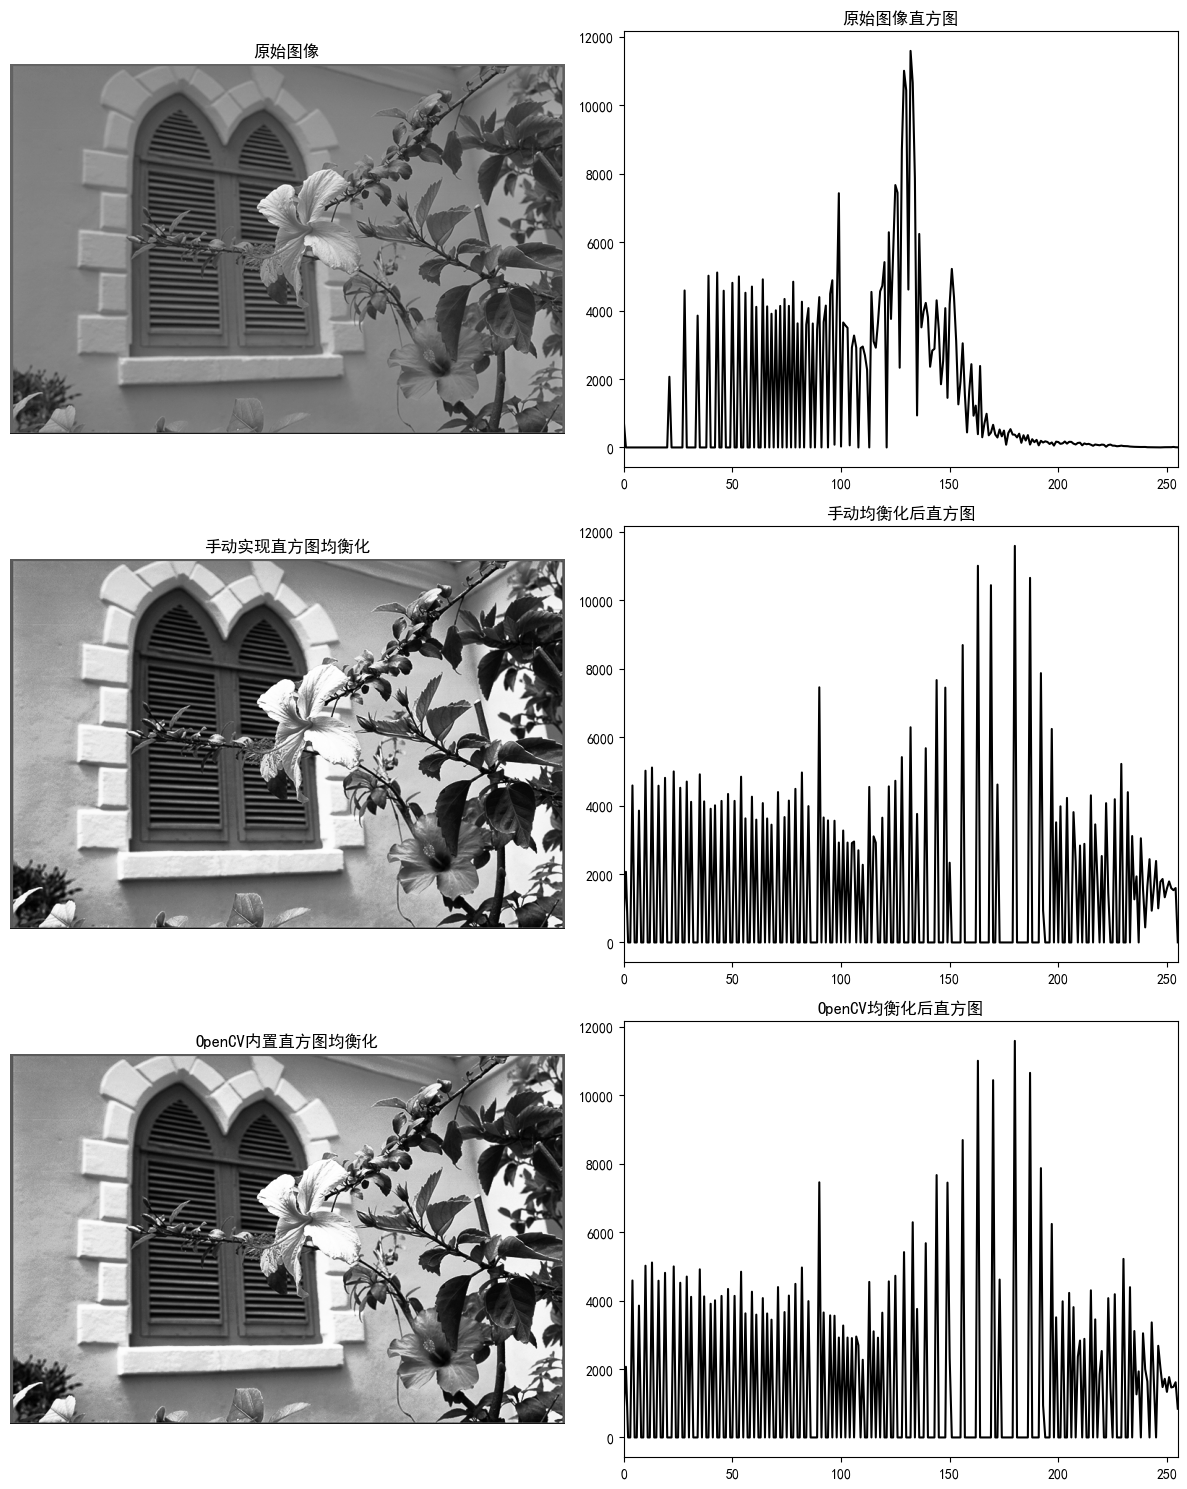

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取灰度图像
img = cv2.imread("test.jpg", cv2.IMREAD_GRAYSCALE)

def manual_hist_equalize(img):
    N = img.size
    L = 256
    hist, _ = np.histogram(img.flatten(), bins=L, range=(0, L))

    cdf = hist.cumsum()
    cdf_normalized = cdf / N

    cdf_mapped = (L - 1) * cdf_normalized
    cdf_mapped = np.uint8(np.clip(cdf_mapped, 0, 255))

    img_equalized = cdf_mapped[img]
    return img_equalized, hist, cdf_normalized

# 执行手动均衡化
img_manual_eq, hist_original, cdf_original = manual_hist_equalize(img)

# OpenCV内置均衡化
img_cv_eq = cv2.equalizeHist(img)

# 计算均衡化后直方图
hist_manual_eq, _ = np.histogram(img_manual_eq.flatten(), bins=256, range=(0, 256))
hist_cv_eq, _ = np.histogram(img_cv_eq.flatten(), bins=256, range=(0, 256))

# 结果可视化
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
axes = axes.flatten()

axes[0].imshow(img, cmap="gray")
axes[0].set_title("原始图像")
axes[0].axis("off")

axes[1].plot(hist_original, color="black")
axes[1].set_title("原始图像直方图")
axes[1].set_xlim([0, 255])

axes[2].imshow(img_manual_eq, cmap="gray")
axes[2].set_title("手动实现直方图均衡化")
axes[2].axis("off")

axes[3].plot(hist_manual_eq, color="black")
axes[3].set_title("手动均衡化后直方图")
axes[3].set_xlim([0, 255])

axes[4].imshow(img_cv_eq, cmap="gray")
axes[4].set_title("OpenCV内置直方图均衡化")
axes[4].axis("off")

axes[5].plot(hist_cv_eq, color="black")
axes[5].set_title("OpenCV均衡化后直方图")
axes[5].set_xlim([0, 255])

plt.tight_layout()
plt.show()

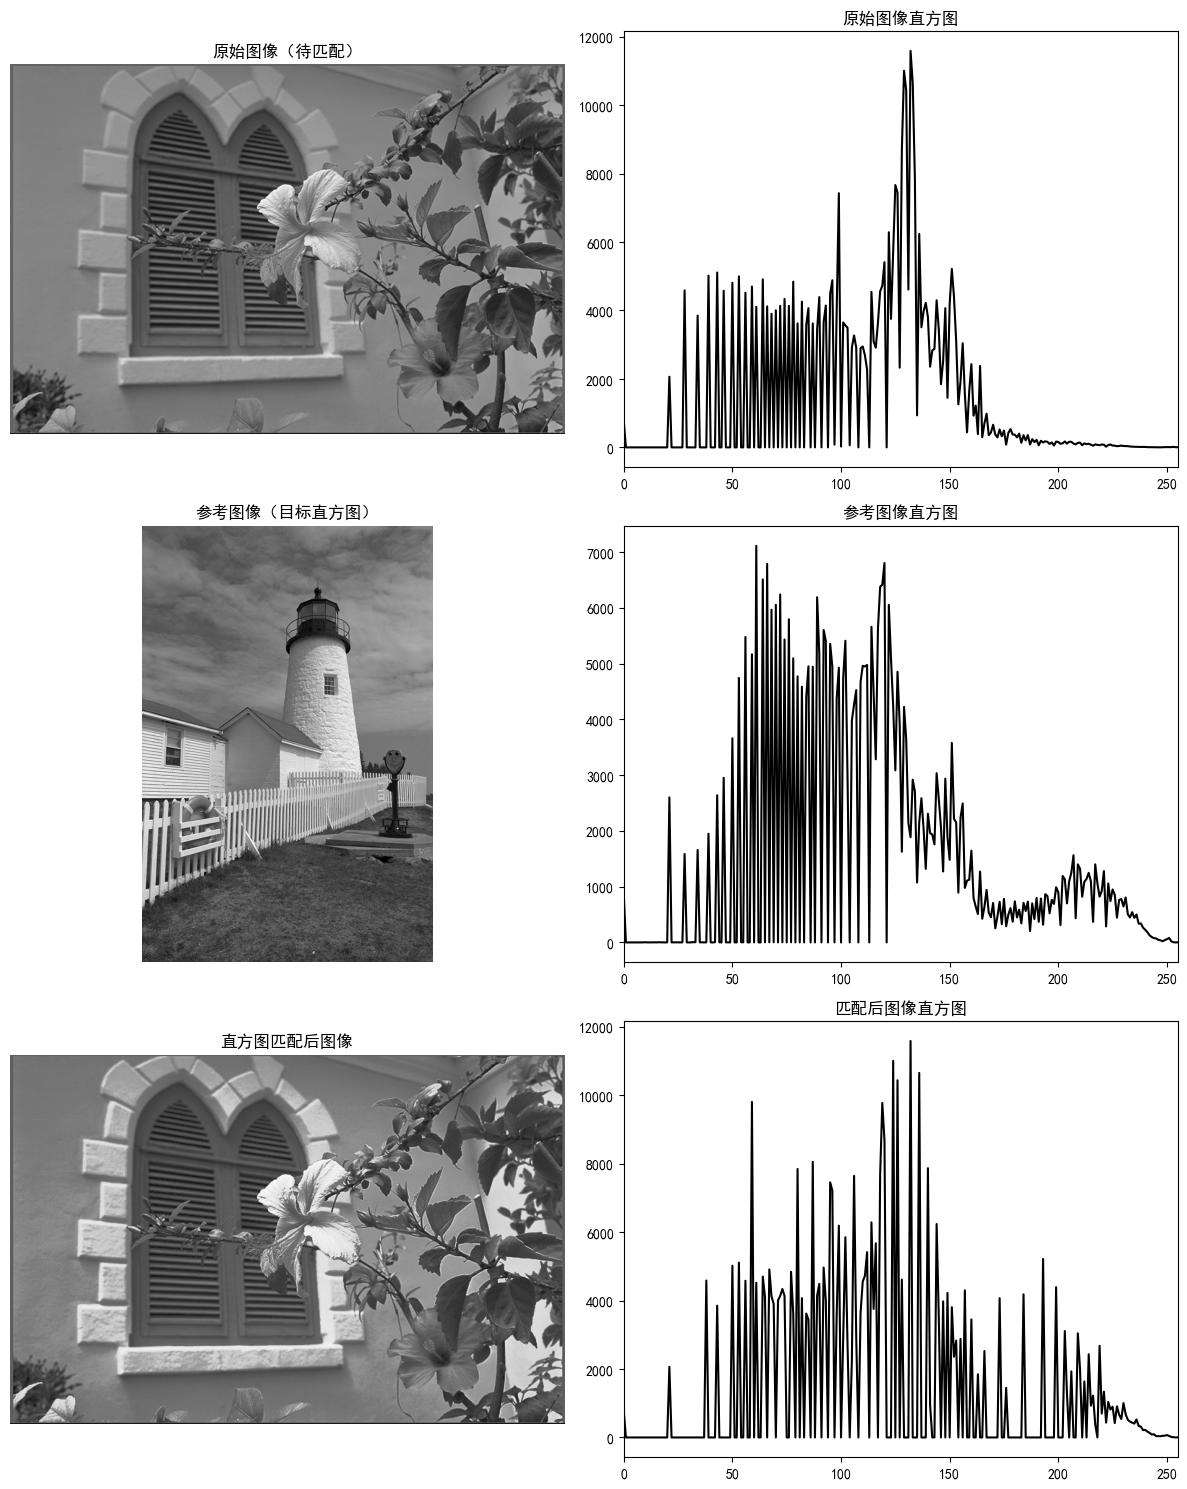

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取原始图像与参考图像
img_source = cv2.imread("test.jpg", cv2.IMREAD_GRAYSCALE)
img_reference = cv2.imread("reference.jpg", cv2.IMREAD_GRAYSCALE)

# 备用：生成模拟图像（无参考图时启用）
# img_source = np.uint8(np.random.normal(100, 30, (400, 400)))
# img_reference = np.uint8(np.random.normal(180, 40, (400, 400)))
# img_source, img_reference = np.clip(img_source, 0, 255), np.clip(img_reference, 0, 255)

def hist_match(source, reference):
    def get_cdf(img):
        N = img.size
        hist, _ = np.histogram(img.flatten(), bins=256, range=(0, 256))
        cdf = hist.cumsum()
        cdf = cdf / N
        cdf = np.clip(cdf, 0, 1)
        return hist, cdf

    hist_src, cdf_src = get_cdf(source)
    hist_ref, cdf_ref = get_cdf(reference)

    mapping_table = np.zeros(256, dtype=np.uint8)
    for i in range(256):
        min_diff = np.min(np.abs(cdf_ref - cdf_src[i]))
        matching_idx = np.where(np.abs(cdf_ref - cdf_src[i]) == min_diff)[0][0]
        mapping_table[i] = matching_idx

    img_matched = mapping_table[source]
    return img_matched, hist_src, hist_ref, hist_match_result(img_matched)

def hist_match_result(img):
    hist, _ = np.histogram(img.flatten(), bins=256, range=(0, 256))
    return hist

# 执行直方图匹配
img_matched, hist_src, hist_ref, hist_matched = hist_match(img_source, img_reference)

# 结果可视化
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
axes = axes.flatten()

axes[0].imshow(img_source, cmap="gray")
axes[0].set_title("原始图像（待匹配）")
axes[0].axis("off")

axes[1].plot(hist_src, color="black")
axes[1].set_title("原始图像直方图")
axes[1].set_xlim([0, 255])

axes[2].imshow(img_reference, cmap="gray")
axes[2].set_title("参考图像（目标直方图）")
axes[2].axis("off")

axes[3].plot(hist_ref, color="black")
axes[3].set_title("参考图像直方图")
axes[3].set_xlim([0, 255])

axes[4].imshow(img_matched, cmap="gray")
axes[4].set_title("直方图匹配后图像")
axes[4].axis("off")

axes[5].plot(hist_matched, color="black")
axes[5].set_title("匹配后图像直方图")
axes[5].set_xlim([0, 255])

plt.tight_layout()
plt.show()